In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')

In [2]:
counts = (pd.read_table('res/rrs.fuse.screen1.uniq.align.screen2.press.screen3.screen4.clust.shared')
            .drop(['label', 'numOtus'],
                  axis='columns')
            .rename(columns={'Group': 'library_id'})
            .set_index('library_id')
         )
#counts

taxonomy = (pd.read_table('res/rrs.fuse.screen1.uniq.align.screen2.press.screen3.screen4.clust.tax',
                          index_col='OTU')
              .Taxonomy
              .str.split('\([0-9]*\);')
              .apply(lambda x: pd.Series(x, index=['Domain', 'Phylum',
                                                   'Class', 'Order',
                                                   'Family', 'Genus',
                                                   'Species']))
              .drop('Species', axis='columns')
           )


libraries = counts.index[counts.index.str.startswith('cult')]

meta = pd.DataFrame({'day': ['D0'] * 2 + ['D1'] * 4 + ['D6'] * 6,
                     'lineage': ['', ''] +
                                ['LIN-0001', 'LIN-0002', 'LIN-0004', 'LIN-0005'] +
                                ['LIN-0001', 'LIN-0002', 'LIN-0003', 'LIN-0004', 'LIN-0005', 'LIN-0006'],
                     'ph': [''] * 2 + ['6', '7'] * 5
                    }, index=libraries)

rabund = counts.loc[libraries].apply(lambda x: x / x.sum(), axis=1)

In [3]:
spike_hits = (pd.read_table('res/rrs.fuse.blastn-spike.tsv',
                            names=['seq_id', 'spike_id',
                                   'identity', 'align_length',
                                   'mismatch', 'gapopen', 'qstart', 'qend',
                                   'sstart', 'send', 'evalue', 'bitscore'],
                            index_col='seq_id')
                [['spike_id', 'identity', 'align_length']])


# Some of the S. alask sequences hits could actually be endemic sequences
spike_hits.drop(spike_hits[lambda x: (x.spike_id == 'sphingopyxis_alaskensis') &
                                     (x.identity < 98)].index,
                inplace=True)

groups = (pd.read_table('res/rrs.fuse.groups',
                        names=['seq_id', 'library_id'], index_col='seq_id'))

spike_data = (spike_hits.join(groups)
                   .groupby(['library_id', 'spike_id'])
                   .identity.count()
                   .unstack()
                   .loc[libraries]
                   .drop('Otu00001', axis='columns')
        )

In [4]:
families = rabund.groupby(taxonomy.Family, axis='columns').sum().mean().sort_values(ascending=False).index
rabund.groupby([meta.ph, meta.day]).mean().groupby(taxonomy.Family, axis='columns').sum().loc[:, families]

Family  Bacteroidales_S24-7_group  Lactobacillaceae  Enterobacteriaceae  \
ph day                                                                    
   D0                    0.524775          0.166712            0.000137   
6  D1                    0.212769          0.598182            0.071066   
   D6                    0.293555          0.119132            0.344080   
7  D1                    0.296770          0.288081            0.057867   
   D6                    0.396658          0.000380            0.349441   

Family  Enterococcaceae  Lachnospiraceae  Ruminococcaceae  \
ph day                                                      
   D0          0.000347         0.160414         0.085790   
6  D1          0.056951         0.024047         0.011678   
   D6          0.237829         0.000581         0.000680   
7  D1          0.213139         0.041074         0.045375   
   D6          0.172914         0.035817         0.024306   

Family  Erysipelotrichaceae  Family_XIII  Rikenellaceae  Bacteroidaceae  \
ph day                                                                    
   D0              0.002806     0.001714       0.016011        0.010399   
6  D1              0.006650     0.000227       0.003985        0.000503   
   D6              0.001191     0.000031       0.000056        0.001616   
7  D1              0.022517     0.016764       0.004289        0.000601   
   D6              0.006781     0.007515       0.000179        0.002616   

Family       ...        Leuconostocaceae  NB1-n_fa  Staphylococcaceae  \
ph day       ...                                                        
   D0        ...                0.000000  0.000000            0.00000   
6  D1        ...                0.000000  0.000000            0.00000   
   D6        ...                0.000013  0.000013            0.00000   
7  D1        ...                0.000000  0.000000            0.00002   
   D6        ...                0.000000  0.000000            0.00000   

Family  Carnobacteriaceae  Oxalobacteraceae  Neisseriaceae  \
ph day                                                       
   D0             0.00000               0.0            0.0   
6  D1             0.00000               0.0            0.0   
   D6             0.00000               0.0            0.0   
7  D1             0.00002               0.0            0.0   
   D6             0.00000               0.0            0.0   

Family  Campylobacteraceae  Thermodesulfobacteriaceae  Fusobacteriaceae  \
ph day                                                                    
   D0                  0.0                        0.0               0.0   
6  D1                  0.0                        0.0               0.0   
   D6                  0.0                        0.0               0.0   
7  D1                  0.0                        0.0               0.0   
   D6                  0.0                        0.0               0.0   

Family  Victivallaceae  
ph day                  
   D0              0.0  
6  D1              0.0  
   D6              0.0  
7  D1              0.0  
   D6              0.0  

[5 rows x 46 columns]

In [5]:
spike_data

spike_id,sphingopyxis_alaskensis,spikeA,spikeB
library_id,,,
cult-D0,524.0,4185.0,2769.0
cult-D0-solids,630.0,3296.0,1974.0
cult-D1-1-6,597.0,5941.0,3819.0
cult-D1-1-7,930.0,5678.0,3404.0
cult-D1-2-6,1129.0,6441.0,3979.0
cult-D1-2-7,617.0,4423.0,2513.0
cult-D6-1-6,1284.0,7033.0,4499.0
cult-D6-1-7,565.0,4116.0,2551.0
cult-D6-2-6,338.0,4961.0,2930.0


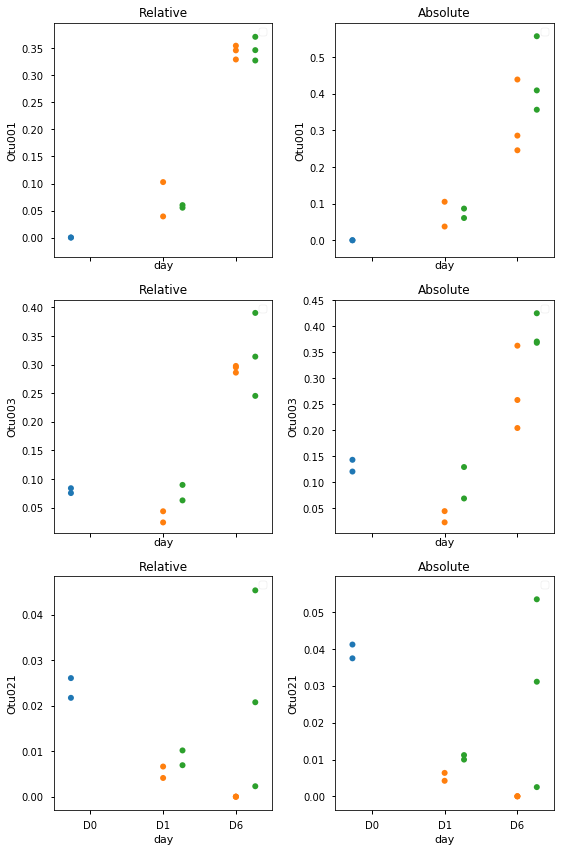

In [17]:
fig, axs = plt.subplots(3, 2, figsize=(8, 12), sharex=True)

for feat, row in zip(['Otu001', 'Otu003', 'Otu021'], axs):
    for ax, d, title in zip(row,
                            [rabund, rabund.div(spike_data.spikeA + spike_data.spikeB, axis='index') * 10000],
                            ['Relative', 'Absolute']):
        sns.stripplot('day', feat, hue='ph',
                  data=d.join(meta),
                  dodge=True, size=6, ax=ax)
        ax.set_title(title)
        ax.legend([])
fig.tight_layout()

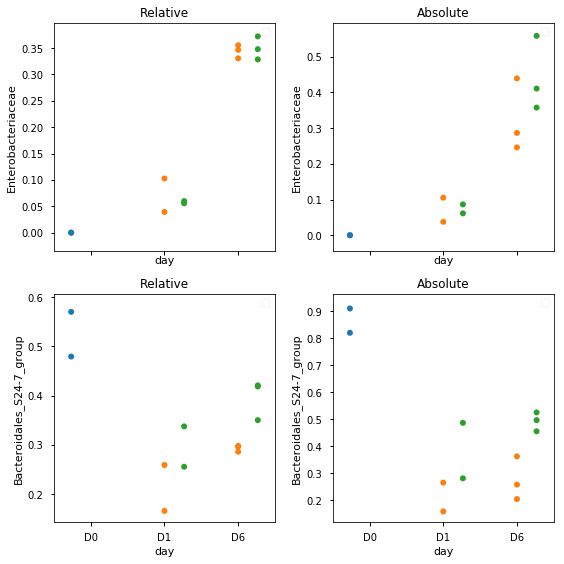

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True)

for feat, row in zip(['Enterobacteriaceae', 'Bacteroidales_S24-7_group'], axs):
    for ax, d, title in zip(row,
                            [rabund, rabund.div(spike_data.spikeA + spike_data.spikeB, axis='index') * 10000],
                            ['Relative', 'Absolute']):
        sns.stripplot('day', feat, hue='ph',
                  data=d.groupby(taxonomy.Family, axis='columns').sum().join(meta),
                  dodge=True, size=6, ax=ax)
        ax.set_title(title)
        ax.legend([])
fig.tight_layout()